# Forecasting with Google Trends

This example creates some forecasting models of time series where Google Trends of search volumes are used as predictors.

## 1. Data

Th example data is number of monthly US visitors to Hong Kong from 1/2007 to 11/2017. Google Trends data is the search volume of keyword: 'Flights to Hong Kong'.

In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import matplotlib.pyplot as plt

visitors = pd.read_csv("tourists.csv")
gtrends = pd.read_csv("gtrends.csv")

### 1.1. Create lagged predictors

* **Visitors_lag_1** - autoregressive
* **Visitors_lag_12** - seasonal adjustment

In [36]:
visitors['Visitors_lag_1'] = visitors['Visitors'].shift(1)
visitors['Visitors_lag_12'] = visitors['Visitors'].shift(12)

### 1.2. Join GT data

* We lag the Google Trend data by one month as it may take some time 

In [37]:
df = pd.concat([visitors, gtrends['Flights to Hong Kong'].shift(1)], axis = 1)
# df

### 1.3. Drop first 12 months data

All remove all non predictors ('Time' and 'Visitors'). You can also use df.pop() function. n_drop records how many data points dropped. 

**skip this section if using the model with month dummy as predictor**

In [38]:
y = df['Visitors'][12:]
x = df.drop(['Time', 'Visitors'], axis = 1)[12:]
n_drop = 12

### 1.4. Use month dummy for seasonality

Instead of using the lag-12 predictor, we find the month from 'Time' and then create month dummy to model seasonal adjustment. After dropping lag-12 predictor, we only need to drop the first month. 

**skip this section if using the model with lag-12 predictor**

In [10]:
df_1 = df.copy()
df_1['Time'] = pd.to_datetime(df_1['Time'])
df_1['Month'] = df_1['Time'].dt.strftime('%b')
df_1 = pd.get_dummies(df_1, columns = ['Month'])

# df_1

In [11]:
y = df_1['Visitors'][1:]
x = df_1.drop(['Time', 'Visitors', 'Visitors_lag_12', 'Month_Jan'], axis = 1)[1:]
n_drop = 1

## 2. Model Calibration

### 2.1. Partition 

We leave the last 11 months 1 - 11/2017 for validation/test. 

In [39]:
y_t = y[:-11]
x_t = x[:-11]

y_v = y[-11:]
x_v = x[-11:]

### 2.2. Linear regression

In [40]:
model = LinearRegression().fit(x_t, y_t)

coef = model.coef_.tolist()
coef.insert(0, model.intercept_)
var = x_t.columns.tolist()
var.insert(0, 'Intercept')
out = pd.DataFrame({'Variable': var, 'Coefficient': coef})
out
# out.to_excel("result.xlsx")

,Variable,Coefficient
0,Intercept,4508.535731
1,Visitors_lag_1,0.127455
2,Visitors_lag_12,0.787024
3,Flights to Hong Kong,71.680933


### 2.3. Model fit on training set

* Use R2
* Plot predicted against real (index does not change after dropping some, so creating x_t_a to use as x-axis)

R2: 0.6626


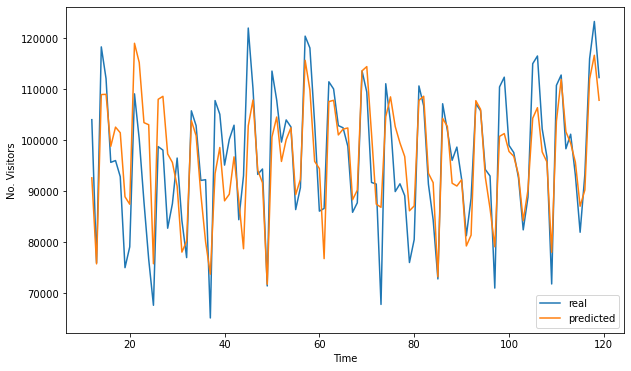

In [41]:
y_t_pred = model.predict(x_t)
print('R2: %.4f' % r2_score(y_t, y_t_pred))

x_t_a = range(n_drop, 120) 
plt.figure(figsize=(10,6))
plt.plot(x_t_a, y_t, label = 'real')
plt.plot(x_t_a, y_t_pred, label = 'predicted')
plt.xlabel("Time")
plt.ylabel("No. Visitors")
plt.legend()
plt.show()

### 2.4. Prediction on validation set

* Use mean error, and RMSE (root mean square error)
* Plot predicted against real (index does not change after dropping some, so creating x_t_a to use as x-axis)

ME: -634.9540
RMSE: 4481.1524


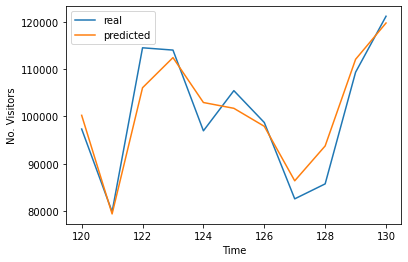

In [42]:
y_v_pred = model.predict(x_v)
print('ME: %.4f' % np.mean(y_v - y_v_pred))
print('RMSE: %.4f' % np.sqrt(mean_squared_error(y_v, y_v_pred)))

x_v_a = range(120, 131)
plt.plot(x_v_a, y_v, label = 'real')
plt.plot(x_v_a, y_v_pred, label = 'predicted')
plt.xlabel("Time")
plt.ylabel("No. Visitors")
plt.legend()
plt.show()